In [98]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from xgboost import XGBClassifier


In [99]:
df = pd.read_csv('water_potability.csv')
df.head(3)

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,NaN,204.890455,20791.318981,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135,0
1,3.716080,129.422921,18630.057858,6.635246,NaN,592.885359,15.180013,56.329076,4.500656,0
2,8.099124,224.236259,19909.541732,9.275884,NaN,418.606213,16.868637,66.420093,3.055934,0


Lets do a quick EDA

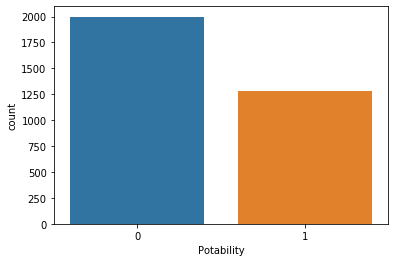

In [100]:
# Lets check out the count split of our targeted binary column

sns.countplot(df['Potability'])

D:\anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:447: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
D:\anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:447: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
D:\anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
D:\anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


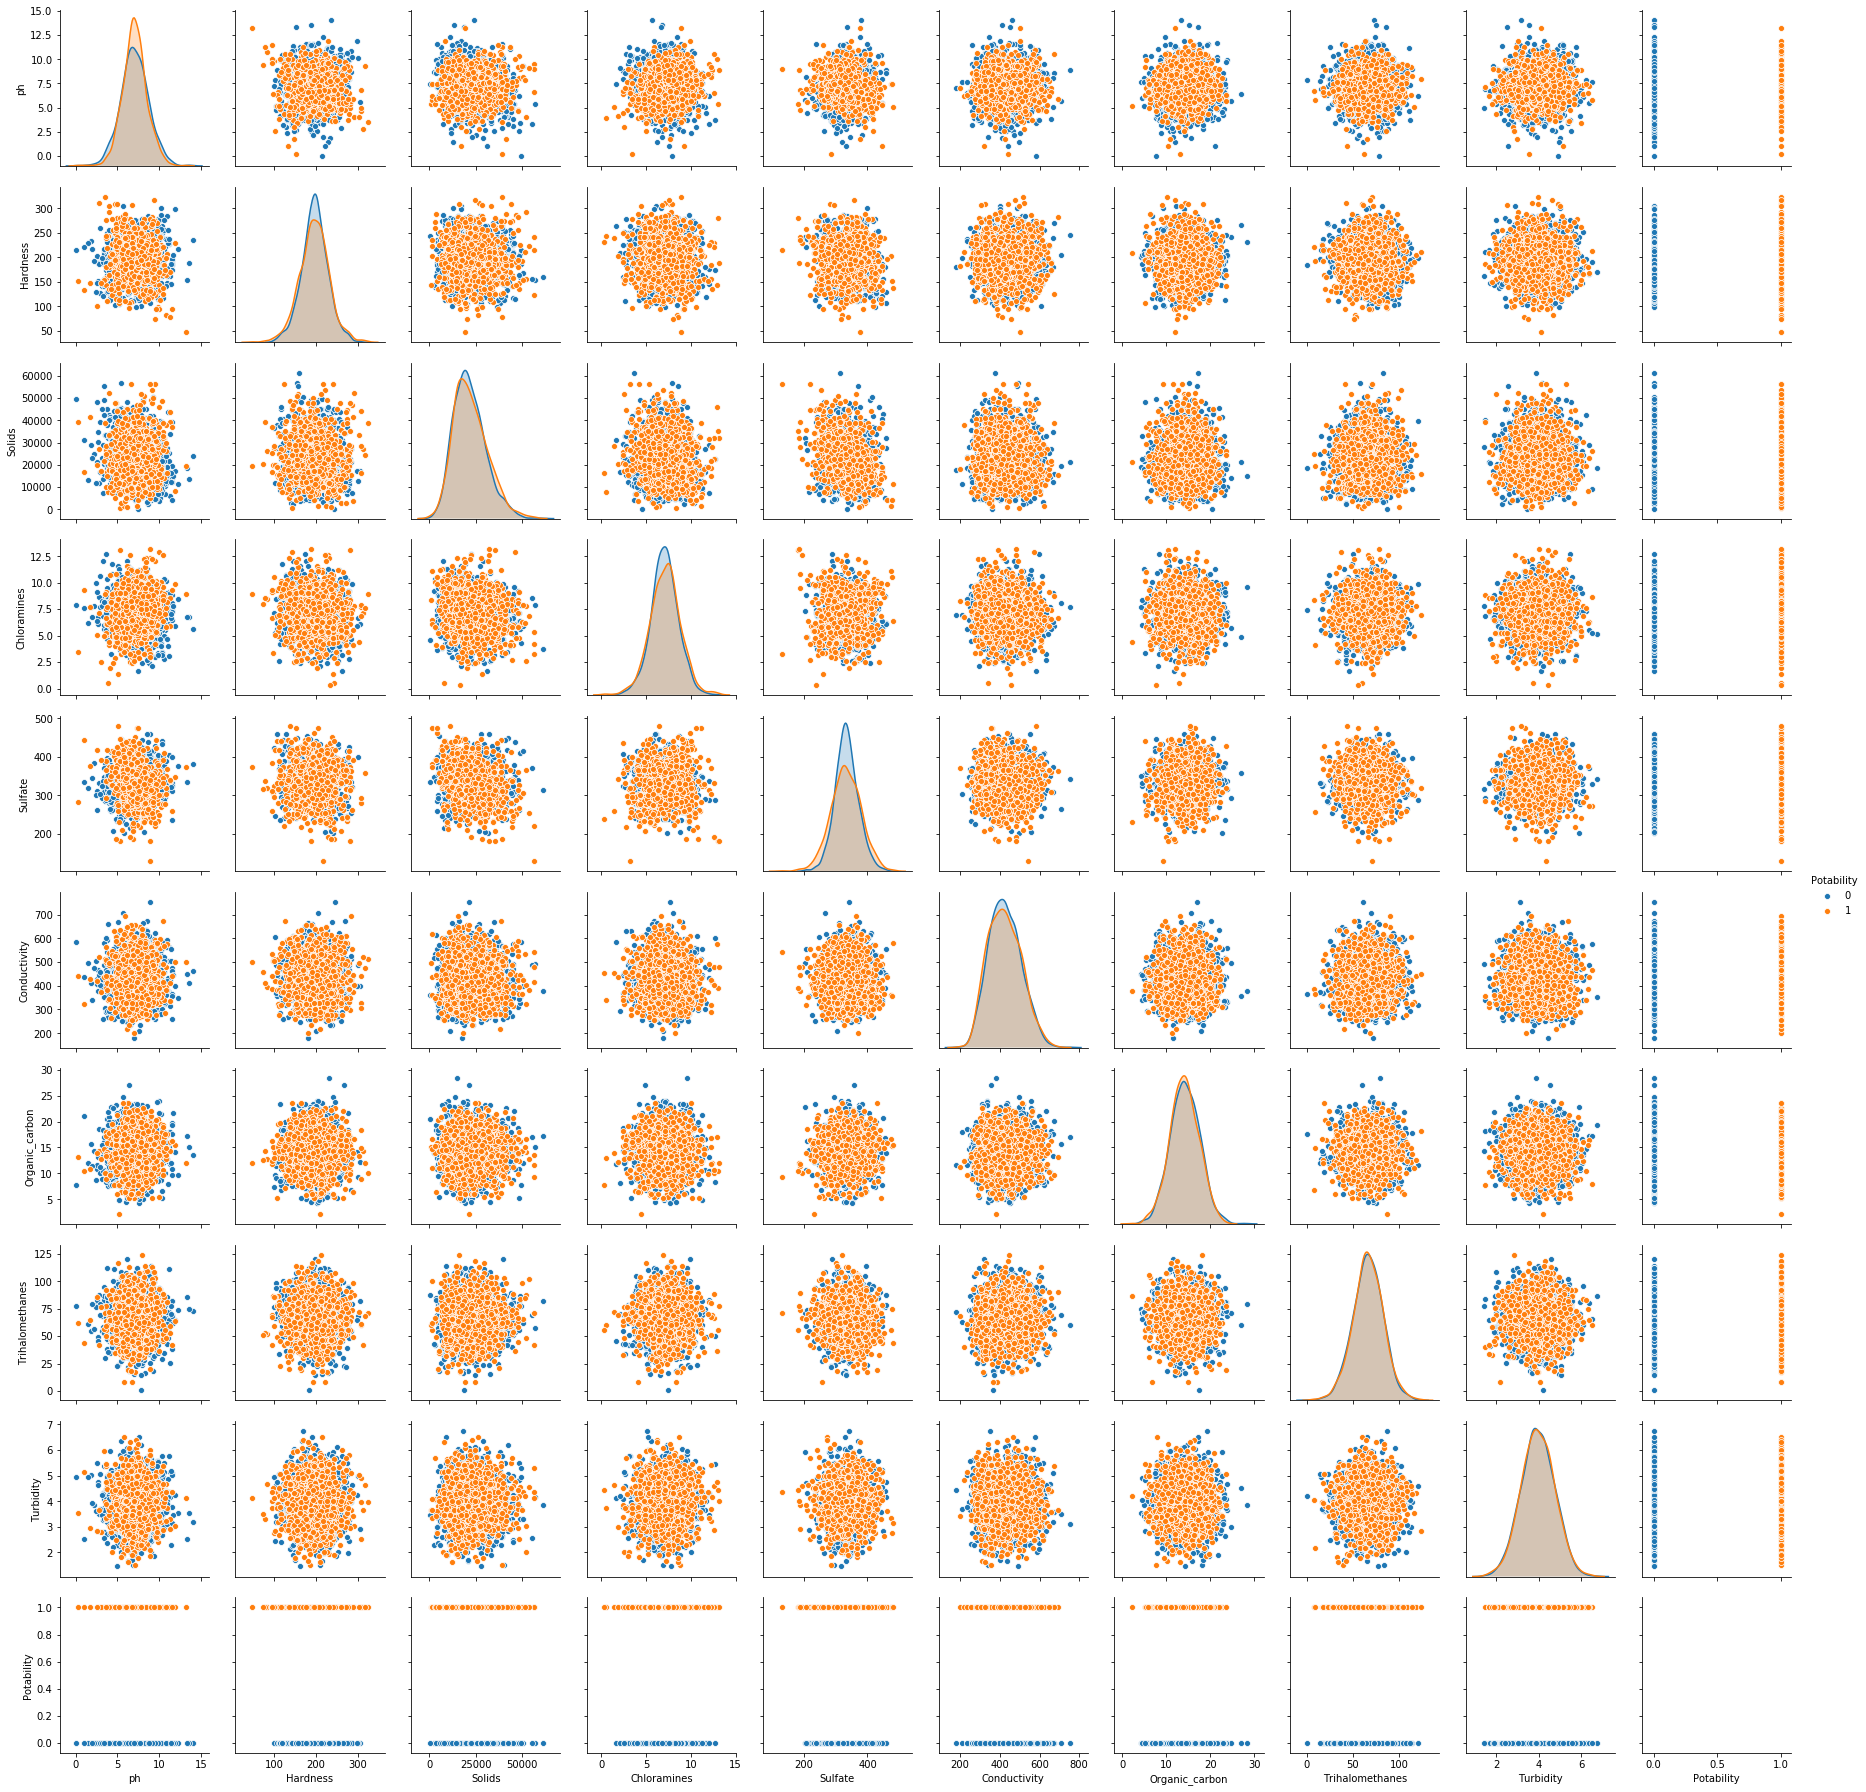

In [101]:
sns.pairplot(df, hue='Potability')

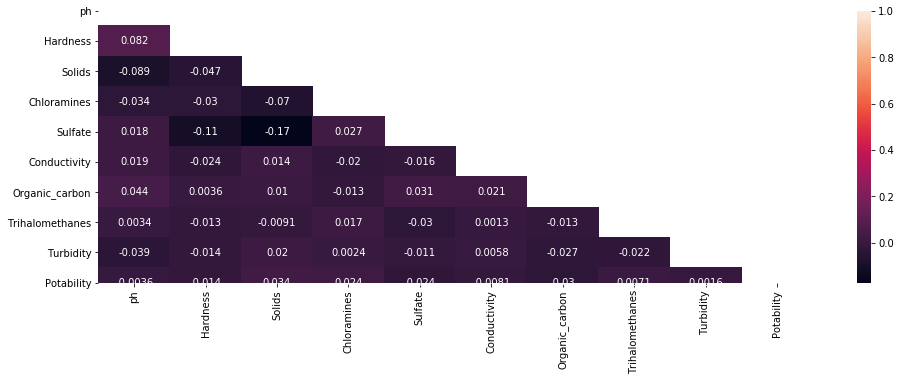

In [102]:
#Heatmap to check for high correlation

hide = np.zeros_like(df.corr())
top_triangle=np.triu_indices_from(hide)
hide[top_triangle] = True

plt.figure(figsize=(16,5))
sns.heatmap(df.corr(), annot=True, mask=hide)

Not a lot of high correlations here

## Lets do some data processing

In [103]:
# Checking for null values

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3276 entries, 0 to 3275
Data columns (total 10 columns):
ph                 2785 non-null float64
Hardness           3276 non-null float64
Solids             3276 non-null float64
Chloramines        3276 non-null float64
Sulfate            2495 non-null float64
Conductivity       3276 non-null float64
Organic_carbon     3276 non-null float64
Trihalomethanes    3114 non-null float64
Turbidity          3276 non-null float64
Potability         3276 non-null int64
dtypes: float64(9), int64(1)
memory usage: 256.1 KB


In [104]:
# High level statistical overview of the data

df.describe()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
count,2785.000000,3276.000000,3276.000000,3276.000000,2495.000000,3276.000000,3276.000000,3114.000000,3276.000000,3276.000000
mean,7.080795,196.369496,22014.092526,7.122277,333.775777,426.205111,14.284970,66.396293,3.966786,0.390110
std,1.594320,32.879761,8768.570828,1.583085,41.416840,80.824064,3.308162,16.175008,0.780382,0.487849
min,0.000000,47.432000,320.942611,0.352000,129.000000,181.483754,2.200000,0.738000,1.450000,0.000000
25%,6.093092,176.850538,15666.690297,6.127421,307.699498,365.734414,12.065801,55.844536,3.439711,0.000000
50%,7.036752,196.967627,20927.833607,7.130299,333.073546,421.884968,14.218338,66.622485,3.955028,0.000000
75%,8.062066,216.667456,27332.762127,8.114887,359.950170,481.792304,16.557652,77.337473,4.500320,1.000000
max,14.000000,323.124000,61227.196008,13.127000,481.030642,753.342620,28.300000,124.000000,6.739000,1.000000


In [105]:
# lets checkout the percentage of missing values 

100*df.isnull().sum()/len(df)

ph                 14.987790
Hardness            0.000000
Solids              0.000000
Chloramines         0.000000
Sulfate            23.840049
Conductivity        0.000000
Organic_carbon      0.000000
Trihalomethanes     4.945055
Turbidity           0.000000
Potability          0.000000
dtype: float64

Lets try to fix the missing values

In [106]:
df['ph'].skew()

0.025630447632210302

In [107]:
df['Sulfate'].skew()

-0.03594662160706183

In [108]:
df['Trihalomethanes'].skew()

-0.08303067407901549

Since the predictors with the missing values are fairly symmetrical, we can simply go ahead and replace the missing values with the mean but lets replace it with the median as the mean gets pulled towards the direction of the outliers instead.

In [109]:
df1=df[df['Potability']==1].copy()
df2=df[df['Potability']==0].copy()
df1['Trihalomethanes']=df1['Trihalomethanes'].replace(np.nan, df1['Trihalomethanes'].median())
df2['Trihalomethanes']=df2['Trihalomethanes'].replace(np.nan, df2['Trihalomethanes'].median())
df1['ph']=df1['ph'].replace(np.nan, df1['ph'].median())
df2['ph']=df2['ph'].replace(np.nan, df2['ph'].median())
df1['Sulfate']=df1['Sulfate'].replace(np.nan, df1['Sulfate'].median())
df2['Sulfate']=df2['Sulfate'].replace(np.nan, df2['Sulfate'].median())

df_final=pd.concat([df1,df2], axis=0, ignore_index=True)
df_final.isnull().sum()

ph                 0
Hardness           0
Solids             0
Chloramines        0
Sulfate            0
Conductivity       0
Organic_carbon     0
Trihalomethanes    0
Turbidity          0
Potability         0
dtype: int64

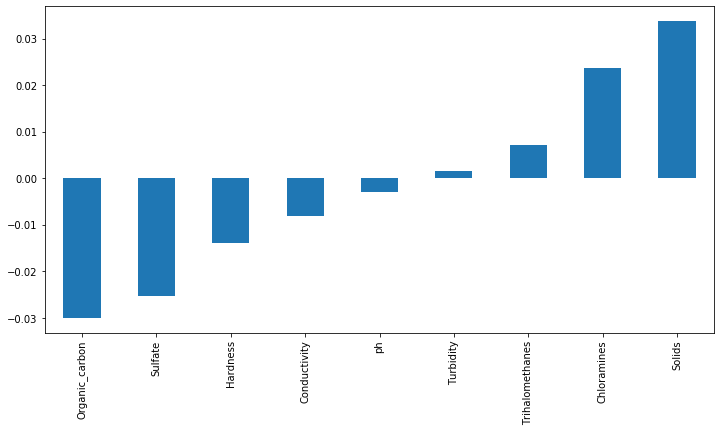

In [110]:
# Lets check for correlation one more time after filling in the NANs
plt.figure(figsize=(12,6))
df_final.corr()['Potability'].sort_values().drop('Potability').plot(kind='bar')

## Now the fun part! Lets build our XGBoost Classification model!

In [111]:
# Dividing the independent and dependent variables

y = df_final["Potability"]
X = df_final.drop('Potability', axis=1)

In [112]:
from sklearn.preprocessing import StandardScaler

In [113]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3, random_state=101)

#this part here is not really needed.

# scale=StandardScaler()
# X_train_scaled=scale.fit_transform(X_train)
# X_test_scaled=scale.transform(X_test)

In [114]:
XGmodel = XGBClassifier()
XGmodel.fit(X_train, y_train)

D:\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[06:32:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, objective='binary:logistic',
              predictor='auto', random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=1, tree_method='exact',
              use_label_encoder=True, validate_parameters=1, verbosity=None)

In [115]:
y_preds = XGmodel.predict(X_test)

In [116]:
print('accuracy Score is ', accuracy_score(y_test, y_preds))
print( confusion_matrix(y_test, y_preds))
print( classification_report(y_test,y_preds))

accuracy Score is  0.7945066124109867
[[524  64]
 [138 257]]
              precision    recall  f1-score   support

           0       0.79      0.89      0.84       588
           1       0.80      0.65      0.72       395

    accuracy                           0.79       983
   macro avg       0.80      0.77      0.78       983
weighted avg       0.80      0.79      0.79       983



It appears this is a great model and can definitely be used to predict the potability of water based on the predictors provided. The recall score (0.89) is really important here since the cost of false positive will be catastrophic!